In [78]:
# Set up matplotlib for inline plotting and apply a specific style for visualizations.
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')  # Use the "fivethirtyeight" style for the plots.
import matplotlib.pyplot as plt  # Import matplotlib's pyplot for creating plots.

In [79]:
# Import the dependencies.
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [80]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [81]:
# Create a connection to the SQLite database
database_path = "../Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

# Test connection
connection = engine.connect()
print("Database connected successfully!")

Database connected successfully!


In [82]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [83]:
# Retrieve the column information for the 'station' table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [84]:
# Retrieve the column information for the 'measurement' table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [85]:
# Automap database into class
Base = automap_base()
Base.prepare(autoload_with=engine)

In [86]:
# Check that all the tables were mapped
Base.classes.keys()

['measurement', 'station']

In [87]:
# Save the mapped tables to objects
Measurement = Base.classes.measurement
Station = Base.classes.station

In [88]:
# Start querying session
session = Session(engine)

# Exploratory Precipitation Analysis

In [89]:
# To find most recent date, arrange dates in descending order and choose first
most_recent_date = session.query(func.max(Measurement.date)).first()
print(f"Most recent date in dataset: {most_recent_date}")

Most recent date in dataset: ('2017-08-23',)


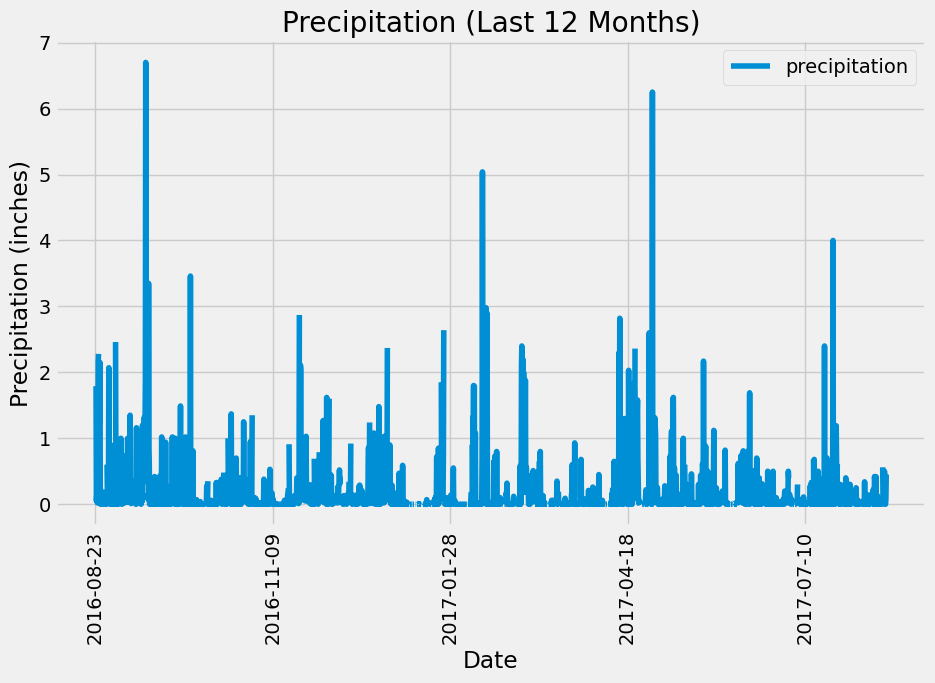

In [90]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date 365 days from the last date in the data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save to dataframe and name columns
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort by date
df = df.sort_values("date")

# Plot with Matplotlib
df.plot(x='date', y='precipitation', figsize=(10, 6), title="Precipitation (Last 12 Months)", rot=90)

# Set the labels
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

# Show the plot
plt.show()

In [91]:
# Extract summary statistics for precipitation
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [92]:
# Count number of stations
total_stations = session.query(func.count(Station.station)).all()
print(f"Total number of stations: {total_stations}")

Total number of stations: [(9,)]


In [93]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print("Most active stations:")
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")

Most active stations:
Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [94]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
print(f"Most active station: {most_active_station}")
temp_stats = session.query(func.min(Measurement.tobs),
                           func.max(Measurement.tobs),
                           func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"Temperature stats for {most_active_station}: {temp_stats}")

Most active station: USC00519281
Temperature stats for USC00519281: [(54.0, 85.0, 71.66378066378067)]


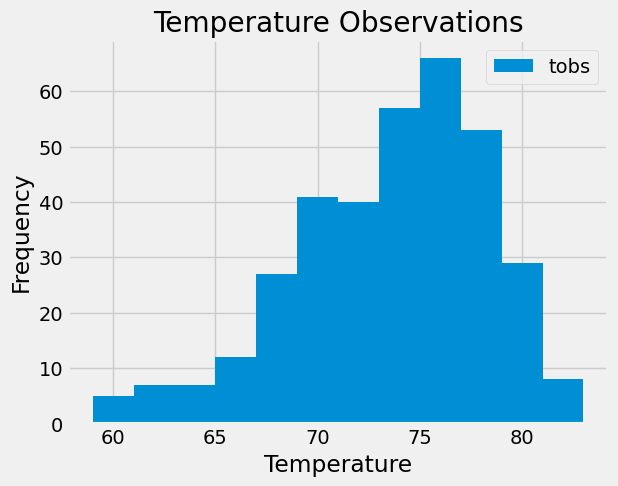

In [97]:
# Last 12 months of temperature for the most active station
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()

# Save the TOBS data to a Pandas DataFrame
df = pd.DataFrame(results, columns=['tobs'])

# Plot the results as a histogram
df.plot.hist(bins=12, title="Temperature Observations")

#Set the labels
plt.tight_layout()
plt.xlabel("Temperature")

# Show the plot
plt.show()

# Close Session

In [96]:
# Close session
session.close()